# $\mathrm{NO_2}$

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "NO2" 
rxns = relevant_rxns(h5_path, species)

13-element Vector{Any}:
 "BrONO2  to  Br and NO3"
 "BrONO2  to  BrO and NO2"
 "ClNO2  to  Cl and NO2"
 "ClNO2  to  Cl and NO2x"
 "ClNO2  to  ClNO and O"
 "ClONO2  to  Cl and NO3"
 "ClONO2  to  ClO and NO2"
 "ClONO2  to  O(3P) and ClONO"
 "IONO2  to  I and NO3"
 "IONO2  to  IO and NO2"
 "N2O5  to  NO3 and NO2"
 "NO2  to  NO and O(3P)"
 "NO3  to  NO2 and O"

In [5]:
rxn = rxns[end-1]

"NO2  to  NO and O(3P)"

In [6]:
λs, Φs, T1s, T2s, species, source_idx, T_units, category, reaction, λ_units, Φ_units  = get_raw_data(h5_path, rxn)

([389.8, 395.1, 399.4, 405.2, 410.2, 419.7, 389.8, 395.1, 399.4, 405.2  …  406.0, 407.0, 408.0, 409.0, 410.0, 411.0, 412.0, 413.0, 414.0, 415.0], [0.74, 0.79, 0.56, 0.26, 0.041, 0.0053, 0.74, 0.79, 0.56, 0.26  …  0.3, 0.26, 0.22, 0.18, 0.15, 0.13, 0.11, 0.09, 0.08, 0.06], [223.0, 300.0, 296.0, 298.0, 298.0, 300.0, 248.0, 298.0, 248.0, 298.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 2, 2, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10], "K", "Nitrogen oxides", "NO2 → NO+O(3P)", "nm", "")

In [7]:
unique(species)

2-element Vector{Int64}:
 1
 2

In [8]:
reaction

"NO2 → NO+O(3P)"

In [9]:
species_to_use = 1 
df = data_to_df(λs, Φs, T1s, T2s, source_idx, species, species_to_use)

Row,λ,Φ,T,source_id
,Float64,Float64,Float64,Int64
1,390.1,0.75,300.0,2
2,395.2,0.82,300.0,2
3,399.8,0.64,300.0,2
4,405.2,0.33,300.0,2
5,410.1,0.12,300.0,2
6,420.8,0.018,300.0,2
7,285.0,1.0,296.0,3
8,290.0,0.999,296.0,3
9,295.0,0.998,296.0,3


In [10]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [11]:
unique(df.T)
unique(df.source_id)

n_sources = size(unique(df.source_id),1)

source_colors = distinguishable_colors(n_sources)

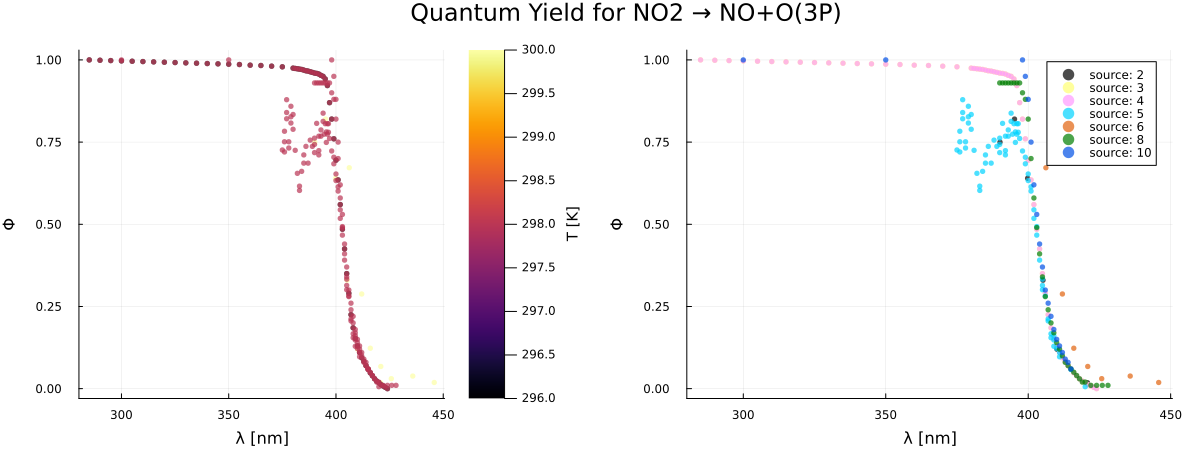

In [12]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    df.Φ[1:nskip:end],
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        df_g.Φ[1:nskip:end],
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="Φ",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Quantum Yield for $(reaction)",)

In [19]:
df = df[df.source_id .!= 2 .&& df.source_id .!= 5 .&& df.source_id .!= 6, :]

Row,λ,Φ,T,source_id
,Float64,Float64,Float64,Int64
1,285.0,1.0,296.0,3
2,290.0,0.999,296.0,3
3,295.0,0.998,296.0,3
4,300.0,0.997,296.0,3
5,305.0,0.996,296.0,3
6,310.0,0.995,296.0,3
7,315.0,0.994,296.0,3
8,320.0,0.993,296.0,3
9,325.0,0.992,296.0,3


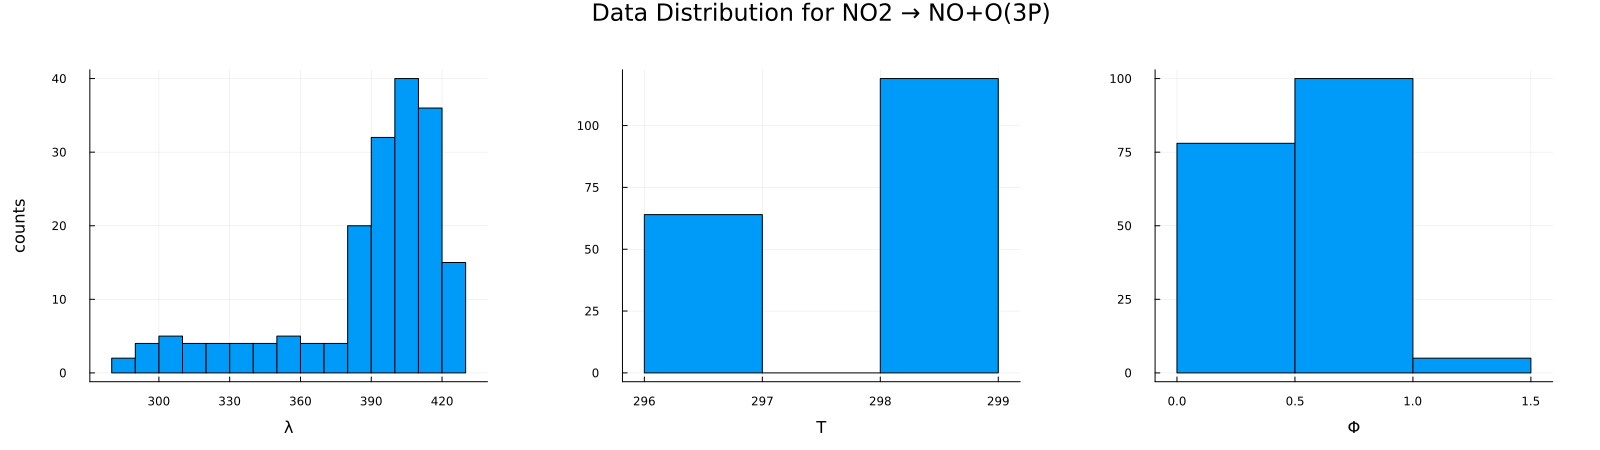

In [20]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df.Φ, xlabel="Φ", label="", margin=10Plots.mm)
phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(reaction)")

# Data Preprocessing

In [21]:
gdfs = groupby(df, :T)

res_dfs = [] 

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:Φ, :T] .=> mean, renamecols=false))
end

df_unique = vcat(res_dfs...)

Row,λ,Φ,T
,Float64,Float64,Float64
1,285.0,1.0,296.0
2,290.0,0.999,296.0
3,295.0,0.998,296.0
4,300.0,0.997,296.0
5,305.0,0.996,296.0
6,310.0,0.995,296.0
7,315.0,0.994,296.0
8,320.0,0.993,296.0
9,325.0,0.992,296.0


In [22]:
# λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
# Φ_idxs = representative_rand_sample(df_unique.Φ, 500, 2000) 
# idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))
# df_sampled = df_unique[idxs_res, :]

df_sampled = df_unique
max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

285.0

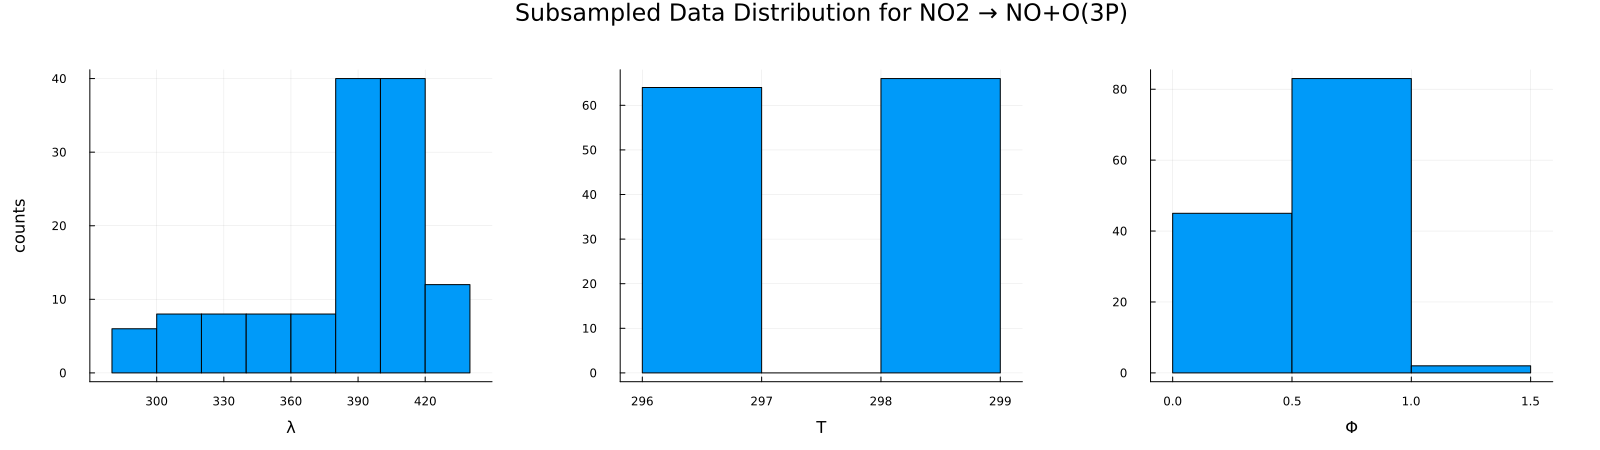

In [23]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df_sampled.Φ, xlabel="Φ", label="", margin=10Plots.mm)

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(reaction)")

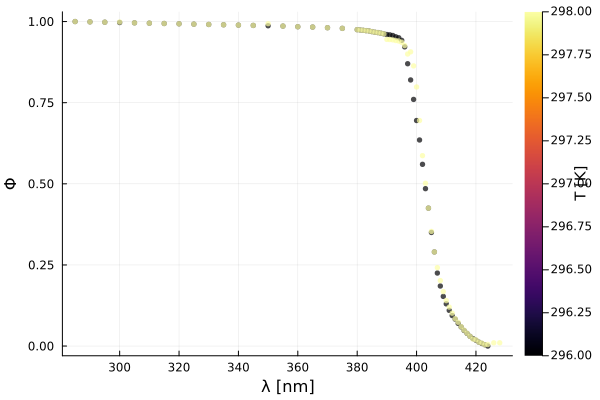

In [24]:
p2 = scatter(
    df_sampled.λ,
    df_sampled.Φ,
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


# GPR Fit

In [25]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

123


In [26]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = df_sampled.Φ[idxs_train]
ytest = df_sampled.Φ[idxs_test]

7-element Vector{Float64}:
 0.9984999999999999
 0.967
 0.971
 0.82
 0.9
 0.981
 0.10133333333333333

In [27]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [28]:
μ_init = 0.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = 0.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-1.7763753053177707, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(3.6432830529582234, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(0.004048590275355649, exp, 1.4901161193847656e-8)), 
  σ² = 0.006770021324951499, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [29]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0    -7.718877e+01     8.199997e+01
 * time: 0.01810908317565918
     1    -1.129989e+02     4.383696e+01
 * time: 1.0141730308532715
     2    -1.429671e+02     2.988177e+01
 * time: 1.0253150463104248
     3    -1.915433e+02     1.202791e+02
 * time: 1.036722183227539
     4    -2.567798e+02     1.287989e+01
 * time: 1.0444340705871582
     5    -2.604022e+02     2.165801e+01
 * time: 1.0570640563964844
     6    -2.707010e+02     5.959147e+01
 * time: 1.0681641101837158
     7    -2.749824e+02     2.309215e+01
 * time: 1.075808048248291
     8    -2.763749e+02     1.311618e+01
 * time: 1.0892751216888428
     9    -2.772092e+02     1.060723e+01
 * time: 1.1366500854492188
    10    -2.807861e+02     8.651760e+00
 * time: 1.1424651145935059
    11    -2.813845e+02     1.220096e+00
 * time: 1.1465401649475098
    12    -2.813943e+02     1.904512e-01
 * time: 1.1511189937591553
    13    -2.813946e+02     5.988313e-02
 * time: 1.15763211250

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @200 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @662 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [30]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [-1.1603115660997712, 2.1927529443650218, 4.244410656287081, -9.015024295486773],
 minimum = -281.3945561520106,
 iterations = 25,
 converged = true,)

In [31]:
fp =fitted_params(mach)

(θ_best = [:σf² => 0.3133885393310668, :ℓ_λ => 8.959845163947797, :ℓ_T => 69.7146621517392],
 σ² = 0.00012158441900456417,)

In [32]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


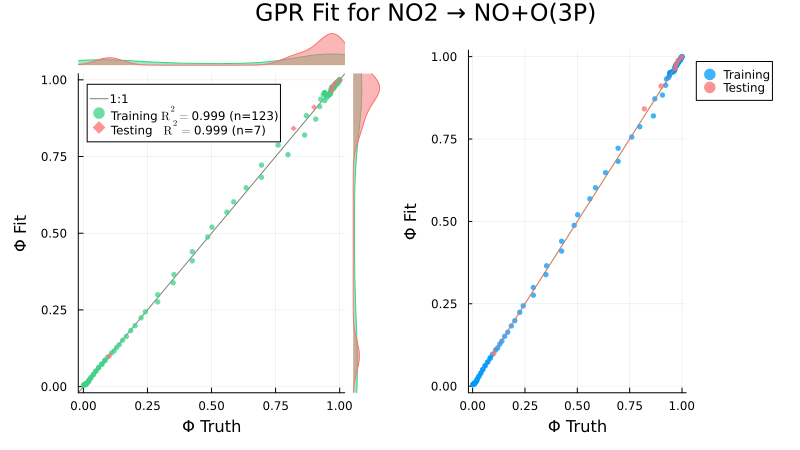

In [33]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

p2 = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

plot(p, p2, layout=(1,2), size=(800, 450), plot_title="GPR Fit for $(reaction)", margins=5Plots.mm)

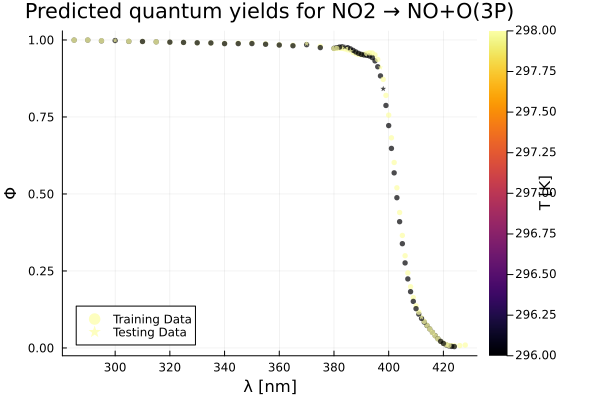

In [34]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted quantum yields for $(reaction)",
    label="Testing Data",
)


285.0
428.0


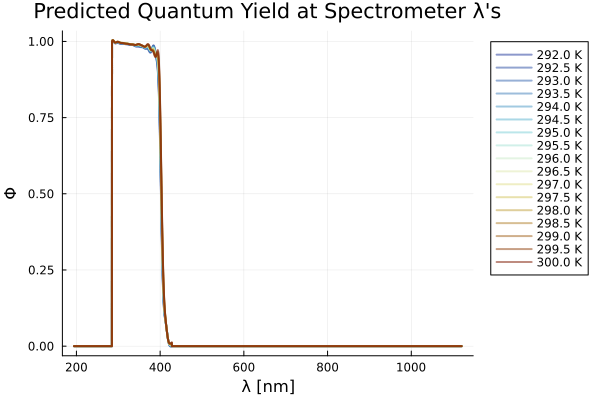

In [35]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_Φ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("Φ")
title!("Predicted Quantum Yield at Spectrometer λ's")